In [21]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 如果你有保存結果，可直接讀取：
# results = pd.read_parquet('../data/processed/backtest_results.parquet')

# 如果你剛跑完可直接使用 walk-forward 結果：
from src.walk_forward import walk_forward_backtest, load_labeled
from src.performance_metrics import summarize_performance

df = load_labeled()
results = walk_forward_backtest(df, start_year=2018, end_year=2024)

results.head()

[LightGBM] [Info] Number of positive: 1384, number of negative: 1150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 2534, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546172 -> initscore=0.185216
[LightGBM] [Info] Start training from score 0.185216
Year 2018 val AUC: 0.5506
[LightGBM] [Info] Number of positive: 1870, number of negative: 1579
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 3449, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542186 -> initscore=0.169147
[LightGBM] [Info] Start training from score 0.16914

,PortRet_1w,BenchRet_1w,ExcessRet_1w,Year
Date,,,,
2018-01-05,0.034255,0.024582,0.009673,2018
2018-01-12,0.035928,0.016458,0.019470,2018
2018-01-19,0.017922,0.008959,0.008963,2018
2018-01-26,0.001118,0.022004,-0.020886,2018
2018-02-02,-0.025854,-0.038837,0.012983,2018


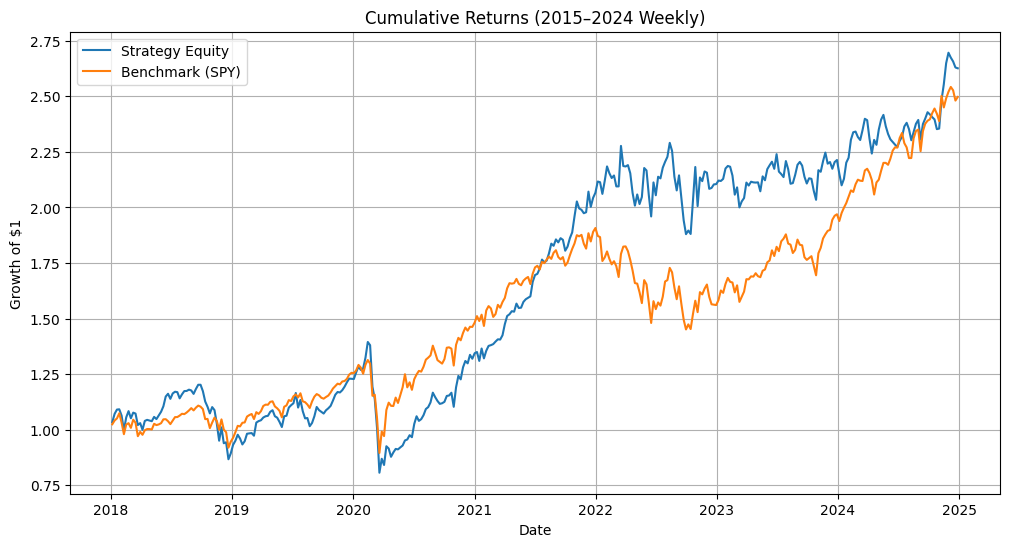

In [23]:
# 建立股權曲線
equity_port = (1 + results["PortRet_1w"]).cumprod()
equity_bench = (1 + results["BenchRet_1w"]).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(equity_port, label="Strategy Equity")
plt.plot(equity_bench, label="Benchmark (SPY)")
plt.title("Cumulative Returns (2015–2024 Weekly)")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.show()

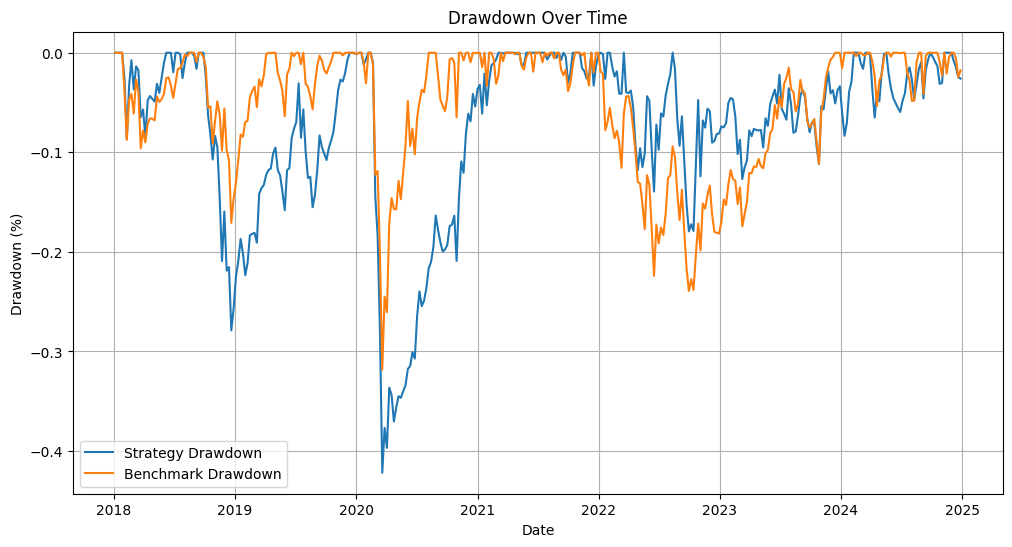

In [24]:
def compute_drawdown(series):
    rolling_max = series.cummax()
    drawdown = series / rolling_max - 1
    return drawdown

dd_port = compute_drawdown(equity_port)
dd_bench = compute_drawdown(equity_bench)

plt.figure(figsize=(12, 6))
plt.plot(dd_port, label="Strategy Drawdown")
plt.plot(dd_bench, label="Benchmark Drawdown")
plt.title("Drawdown Over Time")
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
summary = summarize_performance(results)
summary

=== Performance Summary ===
Port_AnnRet: 0.1760
Port_AnnVol: 0.2198
Port_Sharpe: 0.8009
Port_MaxDD: -0.4217
Bench_AnnRet: 0.1595
Bench_AnnVol: 0.1873
Bench_Sharpe: 0.8516
Bench_MaxDD: -0.3183


{'Port_AnnRet': np.float64(0.17600043877218807),
 'Port_AnnVol': np.float64(0.2197610154273497),
 'Port_Sharpe': np.float64(0.8008719764510356),
 'Port_MaxDD': np.float64(-0.42172159568786516),
 'Bench_AnnRet': np.float64(0.15947781912072467),
 'Bench_AnnVol': np.float64(0.18726506275745833),
 'Bench_Sharpe': np.float64(0.8516154416228557),
 'Bench_MaxDD': np.float64(-0.3182897856392193)}

In [26]:
annual_returns = results.resample("Y")["PortRet_1w"].sum()
annual_returns_bench = results.resample("Y")["BenchRet_1w"].sum()

compare = pd.DataFrame({
    "Strategy Annual Return": (1 + annual_returns) ** 52 - 1,
    "Benchmark Annual Return": (1 + annual_returns_bench) ** 52 - 1
})
compare

/var/folders/p_/wcg3qcf14tjcjw_8md95qf_m0000gn/T/ipykernel_45306/1949407630.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_returns = results.resample("Y")["PortRet_1w"].sum()
/var/folders/p_/wcg3qcf14tjcjw_8md95qf_m0000gn/T/ipykernel_45306/1949407630.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_returns_bench = results.resample("Y")["BenchRet_1w"].sum()


,Strategy Annual Return,Benchmark Annual Return
Date,,
2018-12-31,-9.905042e-01,-0.873699
2019-12-31,3.206161e+06,566221.463567
2020-12-31,7.800759e+02,14674.657586
2021-12-31,3.392951e+08,287845.590243
2022-12-31,1.399400e+01,-0.999953
2023-12-31,2.093305e+01,77932.548855
2024-12-31,5.776241e+03,90068.815162


In [27]:
def calc_sharpe(ret_series):
    return np.sqrt(52) * ret_series.mean() / ret_series.std()

yearly_sharpe = results.groupby(results.index.year)["PortRet_1w"].apply(calc_sharpe)
yearly_sharpe_bench = results.groupby(results.index.year)["BenchRet_1w"].apply(calc_sharpe)

sharpe_table = pd.DataFrame({
    "Strategy Sharpe": yearly_sharpe,
    "Benchmark Sharpe": yearly_sharpe_bench
})
sharpe_table

,Strategy Sharpe,Benchmark Sharpe
Date,,
2018,-0.369136,-0.214464
2019,1.976597,2.661994
2020,0.384514,0.639231
2021,3.465274,2.244862
2022,0.198990,-0.755181
2023,0.411297,1.800018
2024,1.262451,1.991663
